# General Circulation Model

Here we setup and run [MITgcm](https://mitgcm.readthedocs.io/en/latest/). This
general circulation model can simulate the Ocean (as done here), Atmosphere
(plot below), and other components of the climate system accross a wide range
of scales and configurations.

In [1]:
using ClimateModels, MITgcmTools, MeshArrays, Plots, Suppressor

![fig1](https://user-images.githubusercontent.com/20276764/111042787-12377e00-840d-11eb-8ddb-64cc1cfd57fd.png)

## Setup Model

The most standard MITgcm configurations (_verification experiments_) are all available via the `MITgcmTools.jl` package.

In [2]:
exps=verification_experiments()
myexp="global_with_exf"
tmp=[exps[i].configuration==myexp for i in 1:length(exps)]
iexp=findall(tmp)[1];

User can inspect model parameters (e.g. in _data_) via functions also provided by `MITgcmTools.jl` (e.g. `MITgcm_namelist`)

In [3]:
fil=joinpath(MITgcm_path,"verification",exps[iexp].configuration,"input","data")
nml=read(fil,MITgcm_namelist())

MITgcmTools.MITgcm_namelist([:PARM01, :PARM02, :PARM03, :PARM04, :PARM05], OrderedCollections.OrderedDict{Symbol, Any}[OrderedCollections.OrderedDict(:tRef => "15*20.", :sRef => "15*35.", :viscAr => 0.001, :viscAh => 500000.0, :diffKhT => 0.0, :diffKrT => 3.0e-5, :diffKhS => 0.0, :diffKrS => 3.0e-5, :rhoConst => 1035.0, :rotationPeriod => 86400.0…), OrderedCollections.OrderedDict(:cg2dMaxIters => 500, :cg2dTargetResidual => 1.0e-13), OrderedCollections.OrderedDict(:nIter0 => 0, :nTimeSteps => 20, :deltaTmom => 1200.0, :tauCD => 321428.0, :deltaTtracer => 43200.0, :deltaTClock => 43200.0, :abEps => 0.1, :pChkptFreq => 3.1104e8, :dumpFreq => 864000.0, :taveFreq => 864000.0…), OrderedCollections.OrderedDict(:usingSphericalPolarGrid => true, :delR => [50.0, 70.0, 100.0, 140.0, 190.0, 240.0, 290.0, 340.0, 390.0, 440.0, 490.0, 540.0, 590.0, 640.0, 690.0], :ygOrigin => -80.0, :dySpacing => 4.0, :dxSpacing => 4.0), OrderedCollections.OrderedDict(:bathyFile => "bathymetry.bin", :hydrogThetaFile

### Where Is `mitgcmuv` located?

The model executable `mitcmuv` is normally found in the `build/` subfolder of the selected experiment.
If `mitcmuv` is not found at this stage then it is assumed that the chosen model configuration has never been compiled.
Thus we need to compile and run the model a first time via the `build` function.
This might take a lot longer than a normal model run due to the one-time cost of compiling the model.

In [4]:
filexe=joinpath(MITgcm_path,"verification",exps[iexp].configuration,"build","mitgcmuv")
!isfile(filexe) ? build(exps[iexp]) : nothing
pp=joinpath(exps[iexp].folder,string(exps[iexp].ID),"run")
filout=joinpath(pp,"output.txt")
filstat=joinpath(pp,"onestat.txt");

## Run Model

The main model computation takes place here.

In [5]:
@suppress setup(exps[iexp])

@suppress launch(exps[iexp])

### Plot Monitor

Often, _monitor_ denotes a statement / counter printed to standard model output (text file) at regular intervals.
In the example below, we use global mean temperature which is reported every time step as `dynstat_theta_mean`.

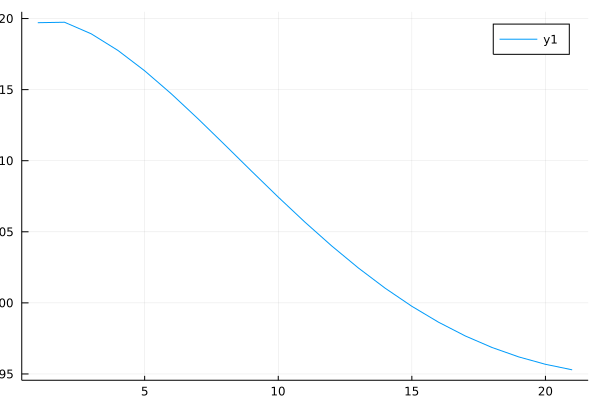

In [6]:
run(pipeline(`grep dynstat_theta_mean $(filout)`,filstat))

tmp0 = read(filstat,String)
tmp0 = split(tmp0,"\n")
Tmean=[parse(Float64,split(tmp0[i],"=")[2]) for i in 1:length(tmp0)-1]
p=plot(Tmean,frmt=:png)

## Plot Results

While such models run, they typically output snapshots and/or time-averages of state variables
in e.g. `binary` or `netcdf` format. Aftewards, e.g. once the model run has completed,
one often wants to reread this output for further analysis. Here, for example, we
reread and plot a temperature field saved at the last time step (`T.0000000020`).

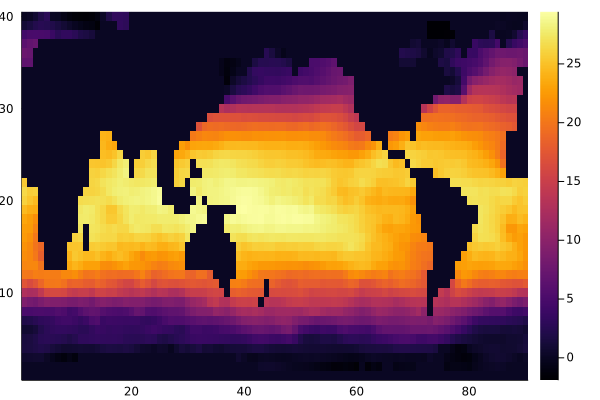

In [7]:
XC=read_mdsio(pp,"XC"); siz=size(XC)

mread(xx::Array,x::MeshArray) = read(xx,x)
function mread(fil::String,x::MeshArray)
	d=dirname(fil)
	b=basename(fil)[1:end-5]
	read(read_mdsio(d,b),x)
end

γ=gcmgrid(pp,"PeriodicChannel",1,fill(siz,1), [siz[1] siz[2]], eltype(XC), mread, write)
Γ=GridLoad(γ)
T=read_mdsio(pp,"T.0000000020")
h=heatmap(T[:,:,1]',frmt=:png)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*